## 目录
1. [SIR传播过程模拟](#1)<br>
2. [构造不同层间网络结构](#2)<br>
&emsp;&emsp; 2.1 [5-6年级为SF无标度网络](#2.1) <br>
&emsp;&emsp; 2.2 [3-4年级SW小世界网络](#2.2) <br>
&emsp;&emsp; 2.3 [1-2年级Regular规则网络](#2.3) <br>
&emsp;&emsp; 2.4 [合并成大网络矩阵](#2.4) <br>
3. [网络结构中SIR传播过程](#3)<br>
&emsp;&emsp; 3.1 [不采取防护措施下，传播过程模拟 ](#3.1) <br>
&emsp;&emsp; 3.2 [戴口罩情况下，传播过程模拟 ](#3.2) <br>
&emsp;&emsp; 3.2 [添加老师节点，产生层内、层间联系，传播过程模拟 ](#3.2) <br>
4. [总结](#4)<br>

[多层网络可视化包MultiNetX链接](https://github.com/nkoub/multinetx)

In [1]:
import networkx as nx
import multinetx as mx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import warnings
warnings.filterwarnings("ignore")

## <a id=1>1. SIR传播过程模拟</a> 
- [数据酷客-参考链接](http://cookdata.cn/note/view_static_note/a34346732ed6107a898fc78663f5c985/)

与传统 SIR 模型类似，网络中的 SIR 模型也有两个重要的参数：感染率 $\beta$ 和恢复率 $\gamma$。需要给每个节点引入一个状态，取值为 S,I,R 中的一种。
每一个时间步中，需要动态对每一个节点的状态进行更新。更新规则如下：

- 如果当前节点是恢复者，则下一步，节点状态依然是恢复者。

![png](http://cookdata.cn/media/note_images/恢复者转变_1587548187643_5d14.jpg)

- 如果当前节点是感染者，则下一步，$\gamma$ 的概率转化为恢复者。$1 - \gamma$ 的概率依然是感染者。

![png](http://cookdata.cn/media/note_images/感染者转变_1587553543947_5d14.jpg)

- 如果当前节点是易感者，则需要计算其邻居节点中感染者的数量，假设其有 $k$ 个邻居为感染者。则该节点下一步转化为感染者的概率为 $1 - (1 - \beta)^k$，否则继续保持易感者状态。

![png](http://cookdata.cn/media/note_images/易感者转变_1587553554737_5d14.jpg)

#### 节点状态模拟更新函数  `updateNodeState`

使用一个简单的函数来实现一个节点的状态的更新。首先，如果一个节点是恢复者，那么下一步还是恢复者，其节点状态保持不变。
如果一个节点是感染者，那么其恢复的概率是 $\gamma$。用程序实现的方法为，先均匀生成一个0到1的随机数 $p$，如果 $p < \gamma$，则节点恢复，否则节点依然处于感染状态。

![png](http://cookdata.cn/media/note_images/gamma图示_1587447702951_5d14.jpg)

如果一个节点是易感者，先要去其邻居节点中看看一共有多少个邻居是感染者，有 $k$ 个邻居是感染者，那么当前节点被感染的概率是 $1 - (1 - \beta)^k$。生成一个0到1的随机数 $p$，如果 $p < 1 - (1 - \beta)^k$，则节点被感染，否则不被感染。

![png](http://cookdata.cn/media/note_images/感染概率图示_1587447711719_5d14.jpg)

`updateNodeState` 函数实现如下所示，其中输入的参数为网络 $G$，节点 $node$，以及 SIR 模型的参数 $\beta$ 和 $\gamma$。

In [2]:
color_dict = {'S':'orange', 'I': 'red', 'R': 'green'}

def updateNodeState(G, node, beta, gamma):
    if G.nodes[node]['state'] == 'I':
        p = random.random()  # 生成一个0-1之间的随机数
        if p < gamma:
            G.nodes[node]['state'] = 'R'
    elif G.nodes[node]['state'] == 'S':
        p = random.random()
        k = 0   # 邻居感染者的数量
        for neighbor in G.adj[node]:
            if G.nodes[neighbor]['state'] == 'I':
                k = k+1
        if p < 1 - (1-beta)**k:
            G.nodes[node]['state'] = 'I'
    return G

def updateNetworkState(G, beta, gamma):
    for node in G:
        updateNodeState(G, node, beta, gamma)

def countSIR(G):
    S = 0
    I = 0
    for node in G:
        if G.nodes[node]['state'] == 'S':
            S = S + 1
        elif G.nodes[node]['state'] == 'I':
            I = I + 1
    return S, I, len(G.nodes) - S - I

def get_node_color(G):
    color_list = []
    for node in G:
        color_list.append(color_dict[G.nodes[node]['state']])
    return color_list

## <a id=2>2. 构造不同层间网络结构</a> 
- 6个年级，每个年级6个班，每班35人；


In [3]:
grade = 6  # 6个年级
classes = 6  # 每个年级6个班
classSize = 35  # 每班35人
p0 = 0.019  # 层间连接联系的概率
p1 = 0.041  # 层内联系的概率

beta = 0.29   # 感染率
gamma = 0.1  # 恢复率

#### 添加环状联系

In [4]:
def Add_circle_intra_links(Diag_AdjMatrix, N):
    '''
    :param Diag_AdjMatrix: 整个大的对角块矩阵
    :param N：大矩阵块中对角线上 小矩阵的大小,假定每个小矩阵块的节点数（N）相等。
    '''
    row = len(Diag_AdjMatrix)  # row = column
    block_num = row // N
    
    for i in range(1, block_num):
        Diag_AdjMatrix[i * N - 1, (i + 1) * N - 1] = 1
        Diag_AdjMatrix[(i + 1) * N - 1, i * N - 1] = 1
        
    return Diag_AdjMatrix 
    

#### 添加随机联系 `random_p `


In [5]:
def Add_random_links(Diag_AdjMatrix, N ,random_p): 
    """
    :param Diag_AdjMatrix: 整个大的对角块矩阵
    :param N：大矩阵块中对角线上 小矩阵的大小,假定每个小矩阵块的节点数（N）相等。
    :param random_p: 为随机变换邻接关系的预设概率参数；
    :return: 大矩阵块（不含对角块）之间产生的联系，结果为稀疏矩阵输出
    """
    row = len(Diag_AdjMatrix)  # row = column
    block_num = row // N
    DiaMatrixRandom = np.random.rand(row, row)
    sparseMatrixLink = mx.lil_matrix(np.zeros((row, row)))  # 生成稀疏矩阵

    for r in range(1, block_num + 1):
        for i in range(row):
            for j in range(row):
                if DiaMatrixRandom[i, j] <= random_p and i < r * N and j >= r * N:
                    sparseMatrixLink[i, j] = 1
                    sparseMatrixLink[j, i] = 1   
    return sparseMatrixLink

### <a id=2.1>2.1 &emsp; 5-6年级为SF无标度网络</a> 

#### 五年级

In [6]:
grade5SFNet1 = mx.generators.barabasi_albert_graph(classSize, 3, seed=201)  # k = 3
grade5SFNet2 = mx.generators.barabasi_albert_graph(classSize, 3, seed=202) 
grade5SFNet3 = mx.generators.barabasi_albert_graph(classSize, 3, seed=203) 
grade5SFNet4 = mx.generators.barabasi_albert_graph(classSize, 3, seed=204) 
grade5SFNet5 = mx.generators.barabasi_albert_graph(classSize, 3, seed=205) 
grade5SFNet6 = mx.generators.barabasi_albert_graph(classSize, 3, seed=206) 

grade5SFNet = mx.MultilayerGraph(list_of_layers=[grade5SFNet1,grade5SFNet2,grade5SFNet3,grade5SFNet4,grade5SFNet5,
                                            grade5SFNet6])
grade5Matrix = mx.adjacency_matrix(grade5SFNet,weight='weight').todense()

grade5circleMatrix = Add_circle_intra_links(grade5Matrix, classSize)

In [7]:
# 添加层内之间的的联系 
grade5diagMatrix= Add_random_links(grade5circleMatrix, classSize , p1)

grade5Net = mx.MultilayerGraph(list_of_layers=[grade5SFNet1,grade5SFNet2,grade5SFNet3,grade5SFNet4,grade5SFNet5,
                                            grade5SFNet6], inter_adjacency_matrix=grade5diagMatrix)


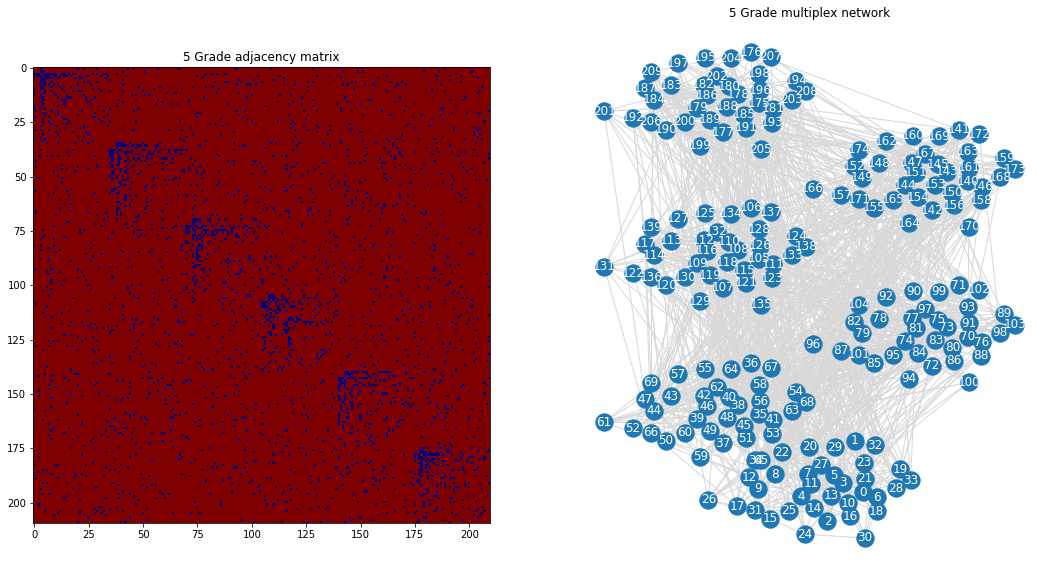

In [8]:
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(121)
ax1.imshow(mx.adjacency_matrix(grade5Net,weight='weight').todense(),
          origin='upper',interpolation='nearest',cmap=plt.cm.jet_r)
ax1.set_title('{} Grade adjacency matrix'.format(5))

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('{} Grade multiplex network'.format(5))
pos = mx.get_position(grade5Net,mx.fruchterman_reingold_layout(grade5Net.get_layer(0)),
                      layer_vertical_shift=.3,
                      layer_horizontal_shift=0.9,
                      proj_angle=.2)
mx.draw_networkx(grade5Net,pos=pos,ax=ax2,with_labels=True, 
                 font_color='white', edge_color = "#D8D8D8",
                 edge_cmap=plt.cm.jet_r)  
plt.show()


#### 六年级

In [9]:
grade6SFNet1 = mx.generators.barabasi_albert_graph(classSize, 4, seed=211)   # k = 4
grade6SFNet2 = mx.generators.barabasi_albert_graph(classSize, 4, seed=212) 
grade6SFNet3 = mx.generators.barabasi_albert_graph(classSize, 4, seed=213) 
grade6SFNet4 = mx.generators.barabasi_albert_graph(classSize, 4, seed=214) 
grade6SFNet5 = mx.generators.barabasi_albert_graph(classSize, 4, seed=215) 
grade6SFNet6 = mx.generators.barabasi_albert_graph(classSize, 4, seed=216) 

grade6SFNet = mx.MultilayerGraph(list_of_layers=[grade6SFNet1,grade6SFNet2,grade6SFNet3,grade6SFNet4,grade6SFNet5,
                                            grade6SFNet6])
grade6Matrix = mx.adjacency_matrix(grade6SFNet,weight='weight').todense()

grade6circleMatrix = Add_circle_intra_links(grade6Matrix, classSize)

In [10]:
# 添加层内之间的的联系 
grade6diagMatrix= Add_random_links(grade6circleMatrix, classSize , p1)

grade6Net = mx.MultilayerGraph(list_of_layers=[grade6SFNet1,grade6SFNet2,grade6SFNet3,grade6SFNet4,grade6SFNet5,
                                            grade6SFNet6], inter_adjacency_matrix=grade6diagMatrix)

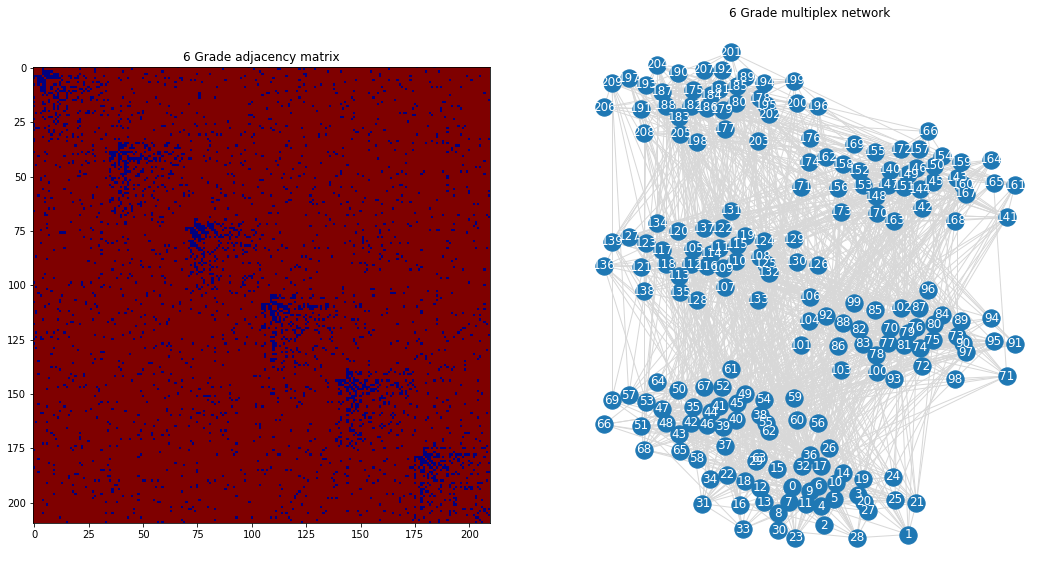

In [11]:
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(121)
ax1.imshow(mx.adjacency_matrix(grade6Net,weight='weight').todense(),
          origin='upper',interpolation='nearest',cmap=plt.cm.jet_r)
ax1.set_title('{} Grade adjacency matrix'.format(6))

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('{} Grade multiplex network'.format(6))
pos = mx.get_position(grade5Net,mx.fruchterman_reingold_layout(grade6Net.get_layer(0)),
                      layer_vertical_shift=.3,
                      layer_horizontal_shift=0.9,
                      proj_angle=.2)
mx.draw_networkx(grade6Net,pos=pos,ax=ax2,with_labels=True, 
                 font_color='white', edge_color = "#D8D8D8",
                 edge_cmap=plt.cm.jet_r)  
plt.show()


### <a id=2.2>2.2 &emsp; 3-4年级小世界网络</a> 

#### 三年级

In [12]:
grade3SWNet1 = mx.generators.newman_watts_strogatz_graph(classSize, 2, 0.5, seed=221)   # k = 2, p=0.5
grade3SWNet2 = mx.generators.newman_watts_strogatz_graph(classSize, 2, 0.5, seed=222)  
grade3SWNet3 = mx.generators.newman_watts_strogatz_graph(classSize, 2, 0.5, seed=223)   
grade3SWNet4 = mx.generators.newman_watts_strogatz_graph(classSize, 2, 0.5, seed=224)   
grade3SWNet5 = mx.generators.newman_watts_strogatz_graph(classSize, 2, 0.5, seed=225)   
grade3SWNet6 = mx.generators.newman_watts_strogatz_graph(classSize, 2, 0.5, seed=226)

grade3SWNet = mx.MultilayerGraph(list_of_layers=[grade3SWNet1,grade3SWNet2,grade3SWNet3,grade3SWNet4,grade3SWNet5,
                                            grade3SWNet6])
grade3Matrix = mx.adjacency_matrix(grade3SWNet,weight='weight').todense()

grade3circleMatrix = Add_circle_intra_links(grade3Matrix, classSize)

In [13]:
# 添加层内之间的的联系 
grade3diagMatrix = Add_random_links(grade3circleMatrix, classSize, p1)

grade3Net = mx.MultilayerGraph(list_of_layers=[grade3SWNet1,grade3SWNet2,grade3SWNet3,grade3SWNet4,grade3SWNet5,
                                            grade3SWNet6], inter_adjacency_matrix=grade3diagMatrix)

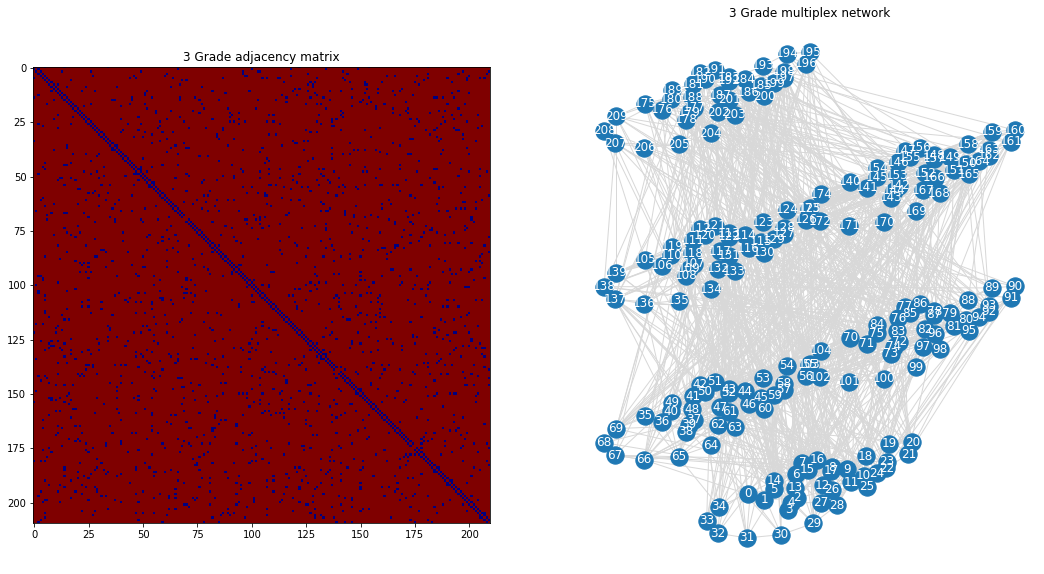

In [14]:
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(121)
ax1.imshow(mx.adjacency_matrix(grade3Net,weight='weight').todense(),
          origin='upper',interpolation='nearest',cmap=plt.cm.jet_r)
ax1.set_title('{} Grade adjacency matrix'.format(3))

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('{} Grade multiplex network'.format(3))
pos = mx.get_position(grade3Net,mx.fruchterman_reingold_layout(grade3Net.get_layer(0)),
                      layer_vertical_shift=.3,
                      layer_horizontal_shift=0.9,
                      proj_angle=.2)
mx.draw_networkx(grade3Net,pos=pos,ax=ax2,with_labels=True, 
                 font_color='white', edge_color = "#D8D8D8",
                 edge_cmap=plt.cm.jet_r)  
plt.show()

#### 四年级

In [15]:
grade4SWNet1 = mx.generators.newman_watts_strogatz_graph(classSize, 3, 0.5, seed=231)   # k = 3,p=0.5
grade4SWNet2 = mx.generators.newman_watts_strogatz_graph(classSize, 3, 0.5, seed=232)  
grade4SWNet3 = mx.generators.newman_watts_strogatz_graph(classSize, 3, 0.5, seed=233)   
grade4SWNet4 = mx.generators.newman_watts_strogatz_graph(classSize, 3, 0.5, seed=234)   
grade4SWNet5 = mx.generators.newman_watts_strogatz_graph(classSize, 3, 0.5, seed=235)   
grade4SWNet6 = mx.generators.newman_watts_strogatz_graph(classSize, 3, 0.5, seed=236)

grade4SWNet = mx.MultilayerGraph(list_of_layers=[grade4SWNet1,grade4SWNet2,grade4SWNet3,grade4SWNet4,grade4SWNet5,
                                            grade4SWNet6])
grade4Matrix = mx.adjacency_matrix(grade4SWNet,weight='weight').todense()

grade4circleMatrix = Add_circle_intra_links(grade4Matrix, classSize)

In [16]:
# 添加层内之间的的联系 
grade4diagMatrix = Add_random_links(grade4circleMatrix, classSize, p1)

grade4Net = mx.MultilayerGraph(list_of_layers=[grade4SWNet1,grade4SWNet2,grade4SWNet3,grade4SWNet4,grade4SWNet5,
                                            grade4SWNet6], inter_adjacency_matrix=grade4diagMatrix)

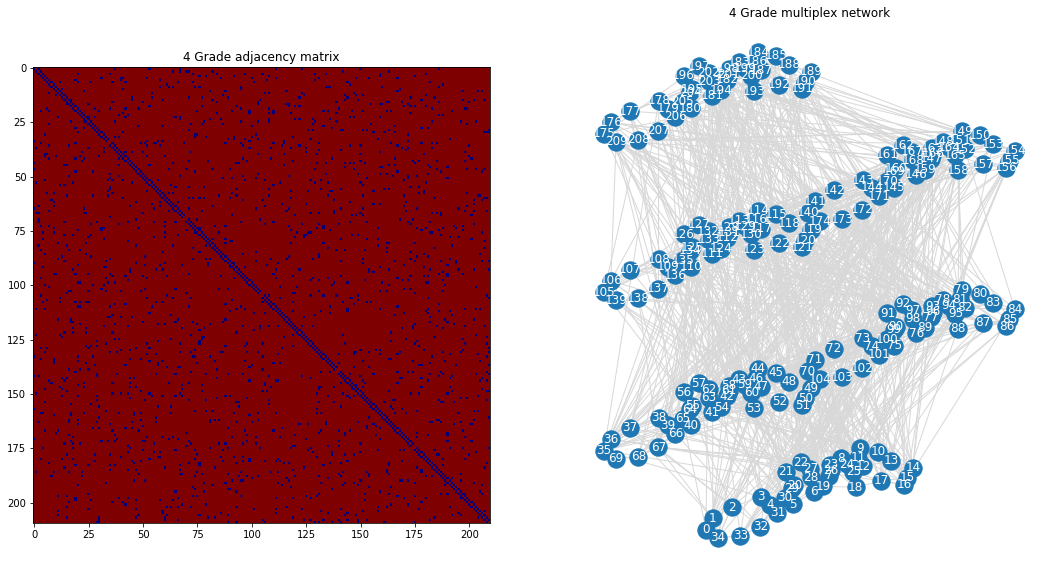

In [17]:
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(121)
ax1.imshow(mx.adjacency_matrix(grade4Net,weight='weight').todense(),
          origin='upper',interpolation='nearest',cmap=plt.cm.jet_r)
ax1.set_title('{} Grade adjacency matrix'.format(4))

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('{} Grade multiplex network'.format(4))
pos = mx.get_position(grade4Net,mx.fruchterman_reingold_layout(grade4Net.get_layer(0)),
                      layer_vertical_shift=.3,
                      layer_horizontal_shift=0.9,
                      proj_angle=.2)
mx.draw_networkx(grade4Net,pos=pos,ax=ax2,with_labels=True, 
                 font_color='white', edge_color = "#D8D8D8",
                 edge_cmap=plt.cm.jet_r)  
plt.show()

### <a id=2.3>2.3 &emsp; 1-2年级规则网络模型 </a> 

#### 一年级

In [18]:
grade1ReNet1 = mx.generators.circulant_graph(classSize, range(3))  # 左右各2个节点相连
grade1ReNet2 = mx.generators.circulant_graph(classSize, range(3))
grade1ReNet3 = mx.generators.circulant_graph(classSize, range(3))
grade1ReNet4 = mx.generators.circulant_graph(classSize, range(3))
grade1ReNet5 = mx.generators.circulant_graph(classSize, range(3))
grade1ReNet6 = mx.generators.circulant_graph(classSize, range(3))

grade1ReNet = mx.MultilayerGraph(list_of_layers=[grade1ReNet1,grade1ReNet2,grade1ReNet3,grade1ReNet4,grade1ReNet5,
                                            grade1ReNet6])
grade1Matrix = mx.adjacency_matrix(grade1ReNet,weight='weight').todense()

grade1circleMatrix = Add_circle_intra_links(grade1Matrix, classSize)

In [19]:
# 添加层内之间的的联系 
grade1diagMatrix = Add_random_links(grade1circleMatrix, classSize, p1)

grade1Net = mx.MultilayerGraph(list_of_layers=[grade1ReNet1,grade1ReNet2,grade1ReNet3,grade1ReNet4,grade1ReNet5,
                                            grade1ReNet6], inter_adjacency_matrix=grade1diagMatrix)

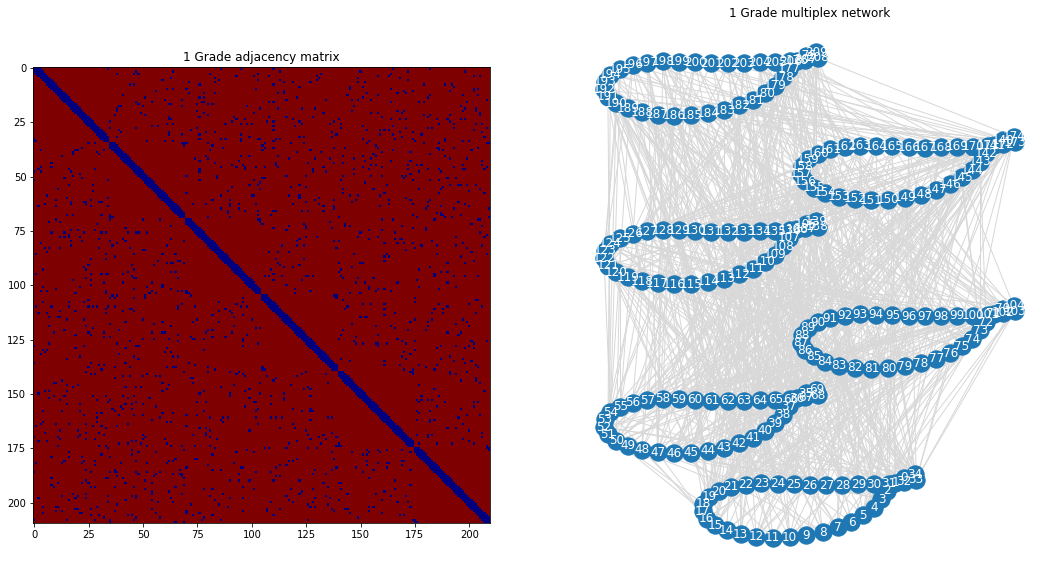

In [20]:
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(121)
ax1.imshow(mx.adjacency_matrix(grade1Net,weight='weight').todense(),
          origin='upper',interpolation='nearest',cmap=plt.cm.jet_r)
ax1.set_title('{} Grade adjacency matrix'.format(1))

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('{} Grade multiplex network'.format(1))
pos = mx.get_position(grade1Net,mx.fruchterman_reingold_layout(grade1Net.get_layer(0)),
                      layer_vertical_shift=.3,
                      layer_horizontal_shift=0.9,
                      proj_angle=.2)
mx.draw_networkx(grade1Net,pos=pos,ax=ax2,with_labels=True, 
                 font_color='white', edge_color = "#D8D8D8",
                 edge_cmap=plt.cm.jet_r)  
plt.show()

#### 二年级

In [21]:
grade2ReNet1 = mx.generators.circulant_graph(classSize, range(4))  # 左右各3个节点相连
grade2ReNet2 = mx.generators.circulant_graph(classSize, range(4))
grade2ReNet3 = mx.generators.circulant_graph(classSize, range(4))
grade2ReNet4 = mx.generators.circulant_graph(classSize, range(4))
grade2ReNet5 = mx.generators.circulant_graph(classSize, range(4))
grade2ReNet6 = mx.generators.circulant_graph(classSize, range(4))

grade2ReNet = mx.MultilayerGraph(list_of_layers=[grade2ReNet1,grade2ReNet2,grade2ReNet3,grade2ReNet4,grade2ReNet5,
                                            grade2ReNet6])
grade2Matrix = mx.adjacency_matrix(grade2ReNet,weight='weight').todense()

grade2circleMatrix = Add_circle_intra_links(grade2Matrix, classSize)

In [22]:
# 添加层内之间的的联系 
grade2diagMatrix = Add_random_links(grade2circleMatrix, classSize, p1)

grade2Net = mx.MultilayerGraph(list_of_layers=[grade2ReNet1,grade2ReNet2,grade2ReNet3,grade2ReNet4,grade2ReNet5,
                                            grade2ReNet6], inter_adjacency_matrix=grade2diagMatrix)

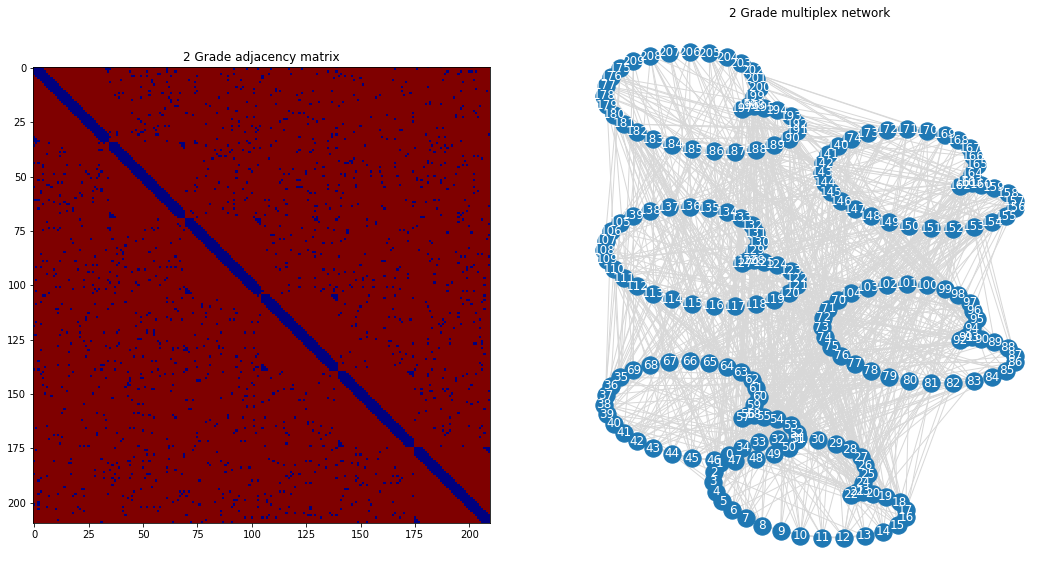

In [23]:
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(121)
ax1.imshow(mx.adjacency_matrix(grade2Net,weight='weight').todense(),
          origin='upper',interpolation='nearest',cmap=plt.cm.jet_r)
ax1.set_title('{} Grade adjacency matrix'.format(2))

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('{} Grade multiplex network'.format(2))
pos = mx.get_position(grade1Net,mx.fruchterman_reingold_layout(grade1Net.get_layer(0)),
                      layer_vertical_shift=.3,
                      layer_horizontal_shift=0.9,
                      proj_angle=.2)
mx.draw_networkx(grade1Net,pos=pos,ax=ax2,with_labels=True, 
                 font_color='white', edge_color = "#D8D8D8",
                 edge_cmap=plt.cm.jet_r)  
plt.show()

### <a id=2.4>2.4 合并成大网络矩阵</a>


In [24]:
GradeDiagNet = mx.MultilayerGraph(list_of_layers=[grade6Net,grade5Net,grade4Net,grade3Net,grade2Net,grade1Net])

GradeDiagNetMatrix = mx.adjacency_matrix(GradeDiagNet,weight='weight').todense()

In [25]:
# 添加层间之间的的联系 
GradeDiagMatrix = Add_random_links(GradeDiagNetMatrix, classSize*classes, p0)

GradeNet = mx.MultilayerGraph(list_of_layers=[grade6Net,grade5Net,grade4Net,grade3Net,grade2Net,grade1Net], 
                               inter_adjacency_matrix=GradeDiagMatrix)

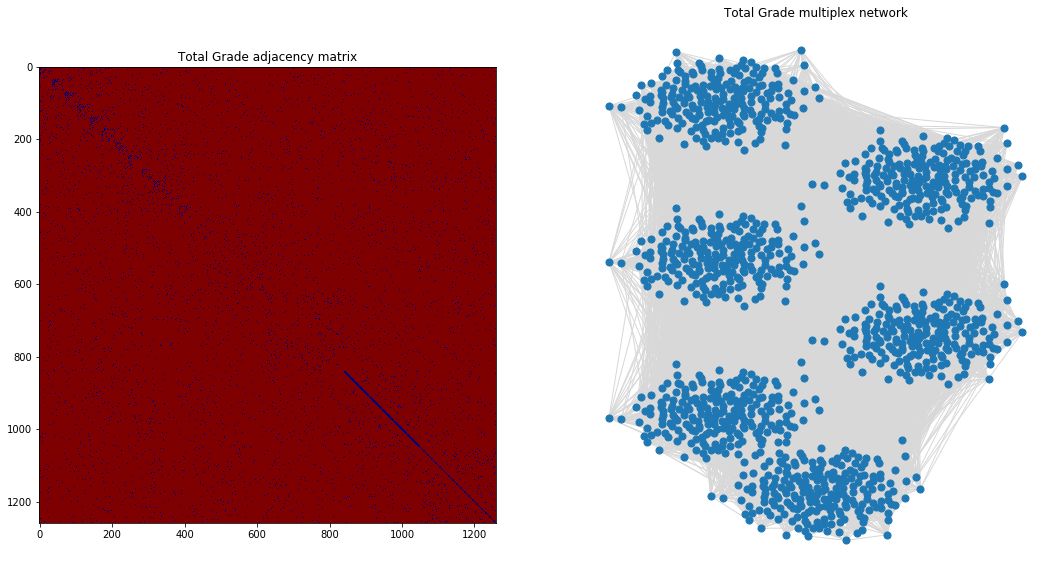

In [26]:
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(121)
ax1.imshow(mx.adjacency_matrix(GradeNet,weight='weight').todense(),
          origin='upper',interpolation='nearest',cmap=plt.cm.jet_r)
ax1.set_title('Total Grade adjacency matrix')

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('Total Grade multiplex network')
pos = mx.get_position(GradeNet,mx.fruchterman_reingold_layout(GradeNet.get_layer(0)),
                      layer_vertical_shift=.3,
                      layer_horizontal_shift=0.9,
                      proj_angle=.2)
mx.draw_networkx(GradeNet,pos=pos,ax=ax2,node_size=50,with_labels=False, 
                 font_color='white', edge_color = "#D8D8D8",
                 edge_cmap=plt.cm.jet_r)  
plt.show()

#### 设置层间和层内权重-便于可视化作图

In [27]:
GradeNet.set_edges_weights(inter_layer_edges_weight=7)

GradeNet.set_intra_edges_weights(layer=0,weight=1)
GradeNet.set_intra_edges_weights(layer=1,weight=2)
GradeNet.set_intra_edges_weights(layer=2,weight=3)
GradeNet.set_intra_edges_weights(layer=3,weight=4)
GradeNet.set_intra_edges_weights(layer=4,weight=5)
GradeNet.set_intra_edges_weights(layer=5,weight=6)

In [28]:
# 计算网络的密度
GradeNetdensity = nx.density(GradeNet)
print(GradeNetdensity)

0.025988123605280078


#### 设置节点初始状态和随机初始感病节点

In [29]:
for node in GradeNet:
    GradeNet.nodes[node]['state'] = 'S'
    

# 设置n个初始染病节点，整个网络总共1260个节点，这里设初始有2个感染节点，I0num=2
I0num = 2
I0seed_node = []
for i in range(I0num):
    seed_node = np.random.randint(0, grade*classes*classSize)
    GradeNet.nodes[seed_node]['state'] = 'I'
    I0seed_node.append(seed_node)
    i += 1


#### 画出图形

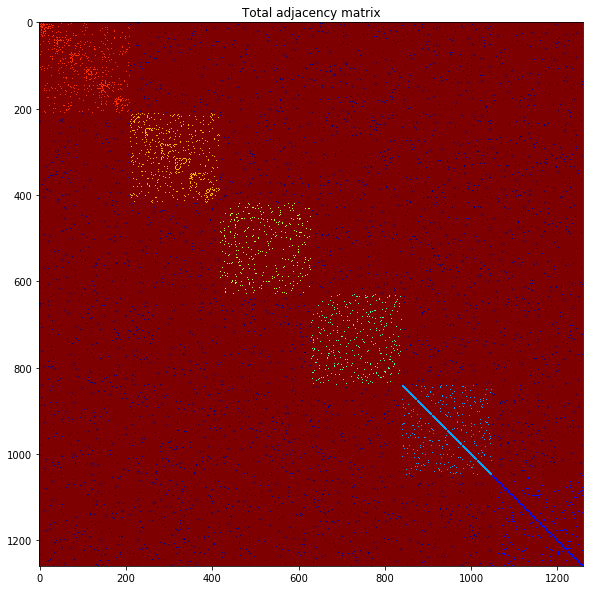

In [30]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot()
ax1.imshow(mx.adjacency_matrix(GradeNet,weight='weight').todense(),
          origin='upper',interpolation='nearest',cmap=plt.cm.jet_r)
ax1.set_title('Total adjacency matrix')

plt.show()

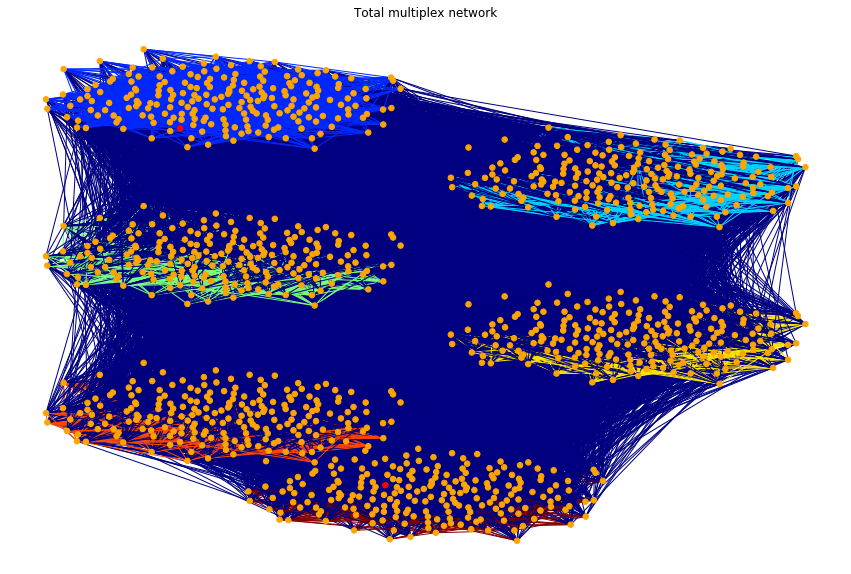

In [31]:
fig = plt.figure(figsize=(15,10))
ax2 = fig.add_subplot()
ax2.axis('off')
ax2.set_title('Total multiplex network')
pos = mx.get_position(GradeNet,mx.fruchterman_reingold_layout(GradeNet.get_layer(0)),
                      layer_vertical_shift=.3,
                      layer_horizontal_shift=0.9,
                      proj_angle=.2)
mx.draw_networkx(GradeNet,pos=pos,ax=ax2,with_labels=False, node_size=30,
                 edge_color=[GradeNet[a][b]['weight'] for a,b in GradeNet.edges()],
                 font_color='white', node_color=get_node_color(GradeNet),
                 edge_cmap=plt.cm.jet_r)  
plt.show()

## <a id=3>3 网络结构中SIR传播过程</a> 
- 测量不同条件下感染人数的峰值和到达峰值的时间
- 不同条件：
    - 网络结构对传播过程影响--不同$p_0,p_1$值
        - 设置`老师节点` ，产生网络间联系（带不同年级的班级或者同一年级班级）
    - 是否戴口罩对感染率`beta`的影响
        - `beta`变化情况，易感者戴口罩感染率降为$30\%beat$，染病者戴口罩感染率降为$5\%beat$，染病者与易感者都戴口罩感染率降为$1.5\%beat$
    - 社交距离对感染率`beta`的影响


&emsp;&emsp;因为模拟过程中网络状态一旦更新后，无法再次通过调用网络更新函数`updateNetworkState()`使网络中节点变为初始态。这里由于多层网络包`multinetX`限制，无法通过深拷贝`cppy.deepcopy()`直接保存网络结构，故将多层网络结构展开为单层网络进行保存。由于整个网络中邻接矩阵不变，故网络结构仅在可视化时表现不一样，其内部联系无变化。

In [32]:
GradeNetMatrix = mx.adjacency_matrix(GradeNet,weight='weight').todense()
GradeNetGraph = nx.from_numpy_matrix(GradeNetMatrix )


### <a id=3.1>3.1 不采取防护措施下，传播过程模拟  </a> 

In [33]:
import copy
GradeNetGraphcp1 = copy.deepcopy(GradeNetGraph)  # 每一次用一个深拷贝的初始网络进行实验 

# 深度拷贝只能保存节点联系，无法保存节点的状态，再次根据前面节点的状态重新确定每个节点状态（与原始态一致）
for node in GradeNetGraphcp1:
    GradeNetGraphcp1.nodes[node]['state'] = 'S'

for i0 in I0seed_node:
    GradeNetGraphcp1.nodes[i0]['state'] = 'I'

In [34]:
# 模拟天数为days，更新节点状态；也可以理解为网络中节点更新次数为100次。
days = 100
SIR1_list = []
for t in range(0, days):
    updateNetworkState(GradeNetGraphcp1, beta, gamma)
    SIR1_list.append(list(countSIR(GradeNetGraphcp1))) 
# print(SIR1_list)

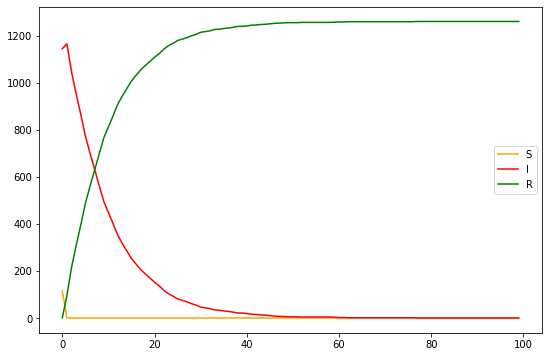

In [35]:
df_SIR1 = pd.DataFrame(SIR1_list, columns=['S', 'I', 'R'])
df_SIR1.plot(figsize=(9,6), color=[color_dict.get(x) for x in df_SIR1.columns])
plt.show()

#### 测量感染人数的峰值和到达峰值的时间无法准确计算，设置相同天数下，以数组中最大值为参考

In [36]:
I1_list = []
for i in range(len(SIR1_list)):
    I1_list.append(SIR1_list[i][1])
i1max = max(I1_list)  # 峰值
i1maxindex = I1_list.index(i1max)  # 到达峰值时间
print(i1max, i1maxindex+1)  # 索引从0开始的

1165 2


### <a id=3.2>3.2 戴口罩情况下，传播过程模拟 </a> 

#### 是否戴口罩对感染率`beta`的影响
  - $\beta$ 变化情况，在初始传染率为$90\%$基础上，易感者戴口罩感染率降为$30\%\beta$，染病者戴口罩感染率降为$5\%\beta$，染病者与易感者都戴口罩感染率降为$1.5\%\beta$

In [37]:
def updateNodeMaskState(G, node, beta, gamma):
    if G.nodes[node]['state'] == 'I':
        p = random.random()  # 生成一个0-1之间的随机数
        if p < gamma:
            G.nodes[node]['state'] = 'R'

    elif G.nodes[node]['state'] == 'S':
        p = random.random()
        k = 0   # 邻居感染者的数量
        kmask = 0  # 邻居感染者带口罩的数量
        for neighbor in G.adj[node]:
            if G.nodes[neighbor]['state'] == 'I':
                k = k+1
                if G.nodes[neighbor]['mask'] == '1':
                    kmask += 1
        if G.nodes[node]['mask'] == '1':
            Beta = (1-0.3*0.9*beta)**(k-kmask) * (1-0.015*0.9*beta)**kmask
            if p < 1 - Beta:
                G.nodes[node]['state'] = 'I'
        else:  # 易感者自身不戴口罩
            Beta = (1-0.9*beta)**(k-kmask) * (1-0.05*0.9*beta)**kmask
            if p < 1 - Beta:
                G.nodes[node]['state'] = 'I'


def updateNetworkMaskState(G, beta, gamma):
    for node in G:
        updateNodeMaskState(G, node, beta, gamma)



##### 画出人群中戴口罩概率与感染人数的关系图

In [38]:
GradeNetGraphcp5 = copy.deepcopy(GradeNetGraph)  # 每一次用一个深拷贝的初始网络进行实验 


listI = []
def maskPro(listp):
    for pp in listp:
        for node in GradeNetGraphcp5:
            GradeNetGraphcp5.nodes[node]['state'] = 'S'
            maskp = random.random()
            if maskp < pp:
                GradeNetGraphcp5.nodes[node]['mask'] = '1'  # 戴口罩
            else:
                GradeNetGraphcp5.nodes[node]['mask'] = '0'  # 不戴口罩
                
        for i0 in I0seed_node:
            GradeNetGraphcp5.nodes[i0]['state'] = 'I'

        SIR5_list = []
        for t in range(0, 30):   # 30天之间最大值 
            updateNetworkMaskState(GradeNetGraphcp5, beta, gamma)
            SIR5_list.append(list(countSIR(GradeNetGraphcp5)))  
        I5_list = []
        for i in range(len(SIR5_list)):
            I5_list.append(SIR5_list[i][1])
        i5max = max(I5_list)
        listI.append(i5max)
    return listI

xx = np.linspace(0,1,41)
listI = maskPro(xx)


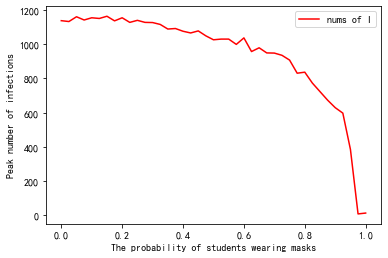

In [39]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 
plt.xlabel('The probability of students wearing masks')
plt.ylabel('Peak number of infections')
plt.plot(xx,listI,label='nums of I',color='red')
plt.legend(loc = 'best')
plt.show()

In [40]:
interval = [abs(listI[i+1]-listI[i]) for i in range(0, len(listI)-1)]
print(interval)

# xx[interval.index(99)]  #  0.775 - 0.85 


[5, 28, 19, 13, 4, 13, 27, 18, 27, 12, 12, 1, 11, 27, 3, 16, 10, 12, 29, 23, 4, 0, 31, 38, 80, 22, 30, 1, 13, 28, 77, 6, 64, 50, 50, 44, 32, 213, 378, 5]


#### 拷贝出网络, 设置网络中节点戴口罩概率进行实验模拟

In [41]:
GradeNetGraphcp2 = copy.deepcopy(GradeNetGraph)  # 每一次用一个深拷贝的初始网络进行实验 

# 更新节点的染病状态（与原先一致），并模拟人群中戴口罩的概念maskp
for node in GradeNetGraphcp2:
    GradeNetGraphcp2.nodes[node]['state'] = 'S'
    maskp = random.random()
    if maskp < 0.8:
        GradeNetGraphcp2.nodes[node]['mask'] = '1'  # 戴口罩
    else:
        GradeNetGraphcp2.nodes[node]['mask'] = '0'  # 不戴口罩

for i0 in I0seed_node:
    GradeNetGraphcp2.nodes[i0]['state'] = 'I'

In [42]:
# 模拟天数为days，更新节点状态；也可以理解为网络中节点更新次数为100次。
days = 100
SIR2_list = []
for t in range(0, days):
    updateNetworkMaskState(GradeNetGraphcp2, beta, gamma)
    SIR2_list.append(list(countSIR(GradeNetGraphcp2))) 

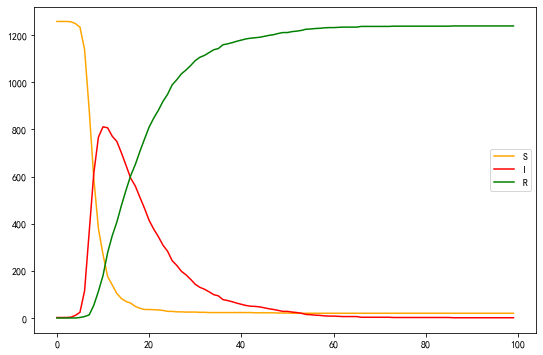

In [43]:
df_SIR2 = pd.DataFrame(SIR2_list, columns=['S', 'I', 'R'])
df_SIR2.plot(figsize=(9,6), color=[color_dict.get(x) for x in df_SIR2.columns])
plt.show()

#### 测量感染人数的峰值和到达峰值的时间无法准确计算，设置相同天数下，以数组中最大值为参考

In [44]:
I2_list = []
for i in range(len(SIR2_list)):
    I2_list.append(SIR2_list[i][1])
i2max = max(I2_list)  # 峰值
i2maxindex = I2_list.index(i2max)   # 到达峰值时间
print(i2max, i2maxindex+1)

811 11


### <a id=3.3>3.3 添加老师节点，产生层内、层间联系，传播过程模拟 </a> 

#### 添加老师节点，添加老师节点类似一个星型网络，一个老师可能带同一年级的不同班级（层内），也可能带不同年级不同班级（层间）。
深拷贝出网路结构

In [45]:
GradeNetGraphcp3 = copy.deepcopy(GradeNetGraph)  # 每一次用一个深拷贝的初始网络进行实验 

### 情况一（层内）：
#### 假设老师给同一年级两个班上课，每个班级产生星形网络（增加一个维度，连接单个网络中所有节点）
- 这里有三种网络类型（5-6年级SF，3-4年级SW，1-2年级Re）
- 选定三种网络中一个年级的两个班 添加老师节点，相当于在矩阵的外围添加了一个尺度，这里考虑到原先网络中的复杂结构关系，故采用在最大矩阵外围增加一个尺度，使$n*n$矩阵变为$n+1 * n+1$矩阵

#### 若老师教高年级（5-6年级）
- 网络节点为最上面两层，6年级网络节点范围0-209，5年级网络节点范围210-419

#### 若老师教中年级（3-4年级）
- 网络节点为中间两层，4年级网络节点范围420-629，3年级网络节点范围630-839

#### 若老师教低年级（1-2年级）
- 网络节点为最上面两层，2年级网络节点范围840-1049，5年级网络节点范围1050-1259

In [46]:
grade1 = random.choice([1,2,3,4,5,6])        # 随机从6个年级网络中选择一个年级
class2s = random.sample([1,2,3,4,5,6], 2)   #  随机选取两个不同的班级

In [47]:
GradeNetGraphcp3Matrix = np.array(nx.adjacency_matrix(GradeNetGraphcp3).todense())
rowLen = GradeNetGraphcp3Matrix.shape[0]  

GradeNetGraphcp3MatrixTeach = np.zeros((rowLen+1, rowLen+1))

In [48]:
if grade1 == 6:  # 选择6年级
    for i in range(1, rowLen+1):
        for j in range(1, rowLen+1):
            GradeNetGraphcp3MatrixTeach[i][j] = GradeNetGraphcp3Matrix[i-1][j-1]  # 复制矩阵
    for k in class2s:  # 6 年级随机选两个班，添加老师节点的全联接
        GradeNetGraphcp3MatrixTeach[0, (k-1)*classSize+1 : k*classSize+1] = 1
        GradeNetGraphcp3MatrixTeach[(k-1)*classSize+1 : k*classSize+1, 0] = 1
        
elif grade1 == 5:  # 选择5年级
    for i in range(1, rowLen+1):
        for j in range(1, rowLen+1):
            GradeNetGraphcp3MatrixTeach[i][j] = GradeNetGraphcp3Matrix[i-1][j-1]  # 复制矩阵
    for k in class2s:  # 5 年级随机选两个班，添加老师节点的全联接
        GradeNetGraphcp3MatrixTeach[0, 210+(k-1)*classSize+1 : 210+k*classSize+1] = 1
        GradeNetGraphcp3MatrixTeach[210+(k-1)*classSize+1 : 210+k*classSize+1, 0] = 1   
        
elif grade1 == 4:  # 选择4年级
    for i in range(1, rowLen+1):
        for j in range(1, rowLen+1):
            GradeNetGraphcp3MatrixTeach[i][j] = GradeNetGraphcp3Matrix[i-1][j-1]  # 复制矩阵
    for k in class2s:  # 4 年级随机选两个班，添加老师节点的全联接
        GradeNetGraphcp3MatrixTeach[0, 420+(k-1)*classSize+1 : 420+k*classSize+1] = 1
        GradeNetGraphcp3MatrixTeach[420+(k-1)*classSize+1 : 420+k*classSize+1, 0] = 1   
        
elif grade1 == 3:  # 选择3年级
    for i in range(1, rowLen+1):
        for j in range(1, rowLen+1):
            GradeNetGraphcp3MatrixTeach[i][j] = GradeNetGraphcp3Matrix[i-1][j-1]  # 复制矩阵
    for k in class2s:  # 3 年级随机选两个班，添加老师节点的全联接
        GradeNetGraphcp3MatrixTeach[0, 630+(k-1)*classSize+1 : 630+k*classSize+1] = 1
        GradeNetGraphcp3MatrixTeach[630+(k-1)*classSize+1 : 630+k*classSize+1, 0] = 1   
        
elif grade1 == 2:  # 选择2年级
    for i in range(1, rowLen+1):
        for j in range(1, rowLen+1):
            GradeNetGraphcp3MatrixTeach[i][j] = GradeNetGraphcp3Matrix[i-1][j-1]  # 复制矩阵
    for k in class2s:  # 2 年级随机选两个班，添加老师节点的全联接
        GradeNetGraphcp3MatrixTeach[0, 840+(k-1)*classSize+1 : 840+k*classSize+1] = 1
        GradeNetGraphcp3MatrixTeach[840+(k-1)*classSize+1 : 840+k*classSize+1, 0] = 1   
        
else:  # 选择1年级
    for i in range(1, rowLen+1):
        for j in range(1, rowLen+1):
            GradeNetGraphcp3MatrixTeach[i][j] = GradeNetGraphcp3Matrix[i-1][j-1]  # 复制矩阵
    for k in class2s:  # 1 年级随机选两个班，添加老师节点的全联接
        GradeNetGraphcp3MatrixTeach[0, 1050+(k-1)*classSize+1 : 1050+k*classSize+1] = 1
        GradeNetGraphcp3MatrixTeach[1050+(k-1)*classSize+1 : 1050+k*classSize+1, 0] = 1   

In [49]:
GradeNetGraphcp3MatrixTeachNet = nx.from_numpy_matrix(GradeNetGraphcp3MatrixTeach)  # 转为网络

#### 额外设置老师为染病者
-  增加一个老师节点在首尾，其他节点索引后移一位（以邻接矩阵为参考对象）

In [50]:
# 更新节点的染病状态（与原先一致），并模拟人群中戴口罩的概念maskp
for node in GradeNetGraphcp3MatrixTeachNet:
    GradeNetGraphcp3MatrixTeachNet.nodes[node]['state'] = 'S'
    maskp = random.random()
    if maskp < 0.8:
        GradeNetGraphcp3MatrixTeachNet.nodes[node]['mask'] = '1'  # 戴口罩
    else:
        GradeNetGraphcp3MatrixTeachNet.nodes[node]['mask'] = '0'  # 不戴口罩

for i0 in I0seed_node[:-1]:  # 老师感染者节点替换掉一个随机感染节点
    GradeNetGraphcp3MatrixTeachNet.nodes[i0+1]['state'] = 'I'  # 节点索引后移一位
    print('随机感染节点：',GradeNetGraphcp3MatrixTeachNet.nodes[i0+1])
    
GradeNetGraphcp3MatrixTeachNet.nodes[0]['state'] = 'I'
print("老师感染节点：",GradeNetGraphcp3MatrixTeachNet.nodes[0])
for i in nx.neighbors(GradeNetGraphcp3MatrixTeachNet, 0):
    print(i, end=' ')

随机感染节点： {'state': 'I', 'mask': '1'}
老师感染节点： {'state': 'I', 'mask': '1'}
666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 801 802 803 804 805 

In [51]:
# 模拟天数为days，更新节点状态；也可以理解为网络中节点更新次数为100次。
days = 100
SIR3_list = []
for t in range(0, days):
    updateNetworkMaskState(GradeNetGraphcp3MatrixTeachNet, beta, gamma)
    SIR3_list.append(list(countSIR(GradeNetGraphcp3MatrixTeachNet))) 

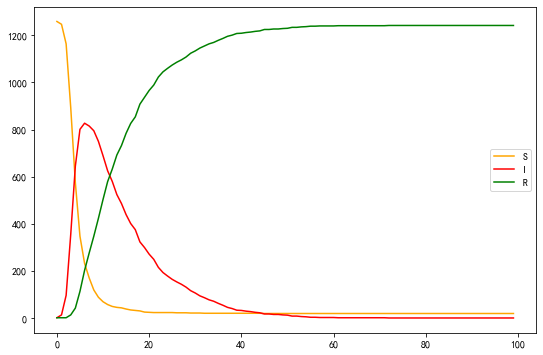

In [52]:
df_SIR3 = pd.DataFrame(SIR3_list, columns=['S', 'I', 'R'])
df_SIR3.plot(figsize=(9,6), color=[color_dict.get(x) for x in df_SIR3.columns])
plt.show()

#### 测量感染人数的峰值和到达峰值的时间无法准确计算，设置相同天数下，以数组中最大值为参考

In [53]:
I3_list = []
for i in range(len(SIR3_list)):
    I3_list.append(SIR3_list[i][1])
i3max = max(I3_list)  # 峰值
i3maxindex = I3_list.index(i3max)   # 到达峰值时间
print(i3max, i3maxindex+1)

827 7


### 情况二（层间）：
#### 假设老师给不同年级两个班上课

In [54]:
GradeNetGraphcp4 = copy.deepcopy(GradeNetGraph)  # 每一次用一个深拷贝的初始网络进行实验 

In [55]:
grade2s = random.sample([1,2,3,4,5,6], 2)      # 随机从6个年级网络中选择两个年级
class2 = random.choice([1,2,3,4,5,6])   #  随机从一个年级选择一个班级, 这里类似于选取一个年级后，必会选班（以班作为观测结果）


In [56]:
GradeNetGraphcp4Matrix = np.array(nx.adjacency_matrix(GradeNetGraphcp4).todense())
rowLen2 = GradeNetGraphcp4Matrix.shape[0]  

GradeNetGraphcp4MatrixTeach = np.zeros((rowLen2+1, rowLen2+1))

In [57]:
for grade in grade2s:
    if grade == 6:  # 选择6年级
        for i in range(1, rowLen2+1):
            for j in range(1, rowLen2+1):
                GradeNetGraphcp4MatrixTeach[i][j] = GradeNetGraphcp4Matrix[i-1][j-1]  
                
        GradeNetGraphcp4MatrixTeach[0, (class2-1)*classSize+1 : class2*classSize+1] = 1
        GradeNetGraphcp4MatrixTeach[(class2-1)*classSize+1 : class2*classSize+1, 0] = 1
    
    elif grade == 5:  # 选择5年级
        for i in range(1, rowLen2+1):
            for j in range(1, rowLen2+1):
                GradeNetGraphcp4MatrixTeach[i][j] = GradeNetGraphcp4Matrix[i-1][j-1]  
                
        GradeNetGraphcp4MatrixTeach[0, 210+(class2-1)*classSize+1 : 210+class2*classSize+1] = 1
        GradeNetGraphcp4MatrixTeach[210+(class2-1)*classSize+1 : 210+class2*classSize+1, 0] = 1
        
    elif grade == 4:  # 选择4年级
        for i in range(1, rowLen2+1):
            for j in range(1, rowLen2+1):
                GradeNetGraphcp4MatrixTeach[i][j] = GradeNetGraphcp4Matrix[i-1][j-1]  
                
        GradeNetGraphcp4MatrixTeach[0, 420+(class2-1)*classSize+1 : 420+class2*classSize+1] = 1
        GradeNetGraphcp4MatrixTeach[420+(class2-1)*classSize+1 : 420+class2*classSize+1, 0] = 1
        
    elif grade == 3:  # 选择3年级
        for i in range(1, rowLen2+1):
            for j in range(1, rowLen2+1):
                GradeNetGraphcp4MatrixTeach[i][j] = GradeNetGraphcp4Matrix[i-1][j-1]  
                
        GradeNetGraphcp4MatrixTeach[0, 630+(class2-1)*classSize+1 : 630+class2*classSize+1] = 1
        GradeNetGraphcp4MatrixTeach[630+(class2-1)*classSize+1 : 630+class2*classSize+1, 0] = 1
        
    elif grade == 2:  # 选择2年级
        for i in range(1, rowLen2+1):
            for j in range(1, rowLen2+1):
                GradeNetGraphcp4MatrixTeach[i][j] = GradeNetGraphcp4Matrix[i-1][j-1]  
                
        GradeNetGraphcp4MatrixTeach[0, 840+(class2-1)*classSize+1 : 840+class2*classSize+1] = 1
        GradeNetGraphcp4MatrixTeach[840+(class2-1)*classSize+1 : 840+class2*classSize+1, 0] = 1
    
    elif grade == 1:  # 选择1年级
        for i in range(1, rowLen2+1):
            for j in range(1, rowLen2+1):
                GradeNetGraphcp4MatrixTeach[i][j] = GradeNetGraphcp4Matrix[i-1][j-1]  
                
        GradeNetGraphcp4MatrixTeach[0, 1050+(class2-1)*classSize+1 : 1050+class2*classSize+1] = 1
        GradeNetGraphcp4MatrixTeach[1050+(class2-1)*classSize+1 : 1050+class2*classSize+1, 0] = 1

In [58]:
GradeNetGraphcp4MatrixTeachNet = nx.from_numpy_matrix(GradeNetGraphcp4MatrixTeach)  # 转为网络

#### 额外设置老师为染病者
-  增加一个老师节点在首尾，其他节点索引后移一位（以邻接矩阵为参考对象）

In [59]:
# 更新节点的染病状态（与原先一致），并模拟人群中戴口罩的概念maskp
for node in GradeNetGraphcp4MatrixTeachNet:
    GradeNetGraphcp4MatrixTeachNet.nodes[node]['state'] = 'S'
    maskp = random.random()
    if maskp < 0.8:
        GradeNetGraphcp4MatrixTeachNet.nodes[node]['mask'] = '1'  # 戴口罩
    else:
        GradeNetGraphcp4MatrixTeachNet.nodes[node]['mask'] = '0'  # 不戴口罩

for i0 in I0seed_node[:-1]:  # 老师感染者节点替换掉一个随机感染节点
    GradeNetGraphcp4MatrixTeachNet.nodes[i0+1]['state'] = 'I'  # 节点索引后移一位
    print('随机感染节点：',GradeNetGraphcp4MatrixTeachNet.nodes[i0+1])

GradeNetGraphcp4MatrixTeachNet.nodes[0]['state'] = 'I'  
print("老师感染节点：",GradeNetGraphcp4MatrixTeachNet.nodes[0])
for i in nx.neighbors(GradeNetGraphcp4MatrixTeachNet, 0):
    print(i, end=' ')

随机感染节点： {'state': 'I', 'mask': '0'}
老师感染节点： {'state': 'I', 'mask': '1'}
71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 

In [60]:
# 模拟天数为days，更新节点状态；也可以理解为网络中节点更新次数为100次。
days = 100
SIR4_list = []
for t in range(0, days):
    updateNetworkMaskState(GradeNetGraphcp4MatrixTeachNet, beta, gamma)
    SIR4_list.append(list(countSIR(GradeNetGraphcp4MatrixTeachNet))) 

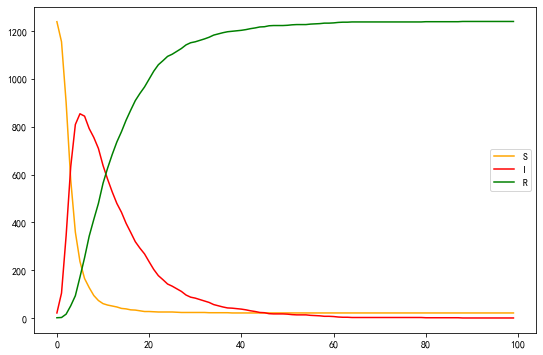

In [61]:
df_SIR4 = pd.DataFrame(SIR4_list, columns=['S', 'I', 'R'])
df_SIR4.plot(figsize=(9,6), color=[color_dict.get(x) for x in df_SIR4.columns])
plt.show()

#### 测量感染人数的峰值和到达峰值的时间无法准确计算，设置相同天数下，以数组中最大值为参考

In [62]:
I4_list = []
for i in range(len(SIR4_list)):
    I4_list.append(SIR4_list[i][1])
i4max = max(I4_list)  # 峰值
i4maxindex = I4_list.index(i4max)   # 到达峰值时间
print(i4max, i4maxindex+1)

854 6


#### 将4个图画在一起

In [63]:
x = [i for i in range(100)]
list1_S = df_SIR1['S'].tolist()
list1_I = df_SIR1['I'].tolist()
list1_R = df_SIR1['R'].tolist()

list2_S = df_SIR2['S'].tolist()
list2_I = df_SIR2['I'].tolist()
list2_R = df_SIR2['R'].tolist()

list3_S = df_SIR3['S'].tolist()
list3_I = df_SIR3['I'].tolist()
list3_R = df_SIR3['R'].tolist()

list4_S = df_SIR4['S'].tolist()
list4_I = df_SIR4['I'].tolist()
list4_R = df_SIR4['R'].tolist()

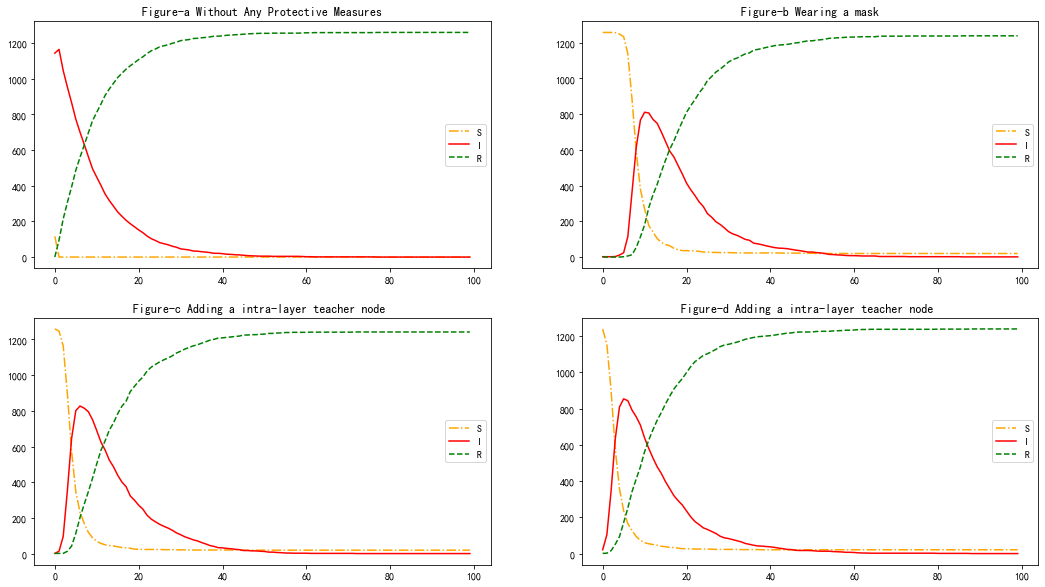

In [64]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(221)
plt.plot(x, list1_S, label='S', color='orange',linestyle = "-.")
plt.plot(x, list1_I, label='I', color='red')
plt.plot(x, list1_R, label='R', color='green',linestyle = "--")

plt.title("Figure-a Without Any Protective Measures") 
plt.legend(loc = 'best')

ax2 = plt.subplot(222)
plt.plot(x, list2_S, label='S', color='orange',linestyle = "-.")
plt.plot(x, list2_I, label='I', color='red')
plt.plot(x, list2_R, label='R', color='green',linestyle = "--")
plt.title("Figure-b Wearing a mask") 
plt.legend(loc = 'best')


ax3 = plt.subplot(223)
plt.plot(x, list3_S, label='S', color='orange',linestyle = "-.")
plt.plot(x, list3_I, label='I', color='red')
plt.plot(x, list3_R, label='R', color='green',linestyle = "--")
plt.title("Figure-c Adding a intra-layer teacher node ") 
plt.legend(loc = 'best')

ax4 = plt.subplot(224)
plt.plot(x, list4_S, label='S', color='orange',linestyle = "-.")
plt.plot(x, list4_I, label='I', color='red')
plt.plot(x, list4_R, label='R', color='green',linestyle = "--")
plt.title("Figure-d Adding a intra-layer teacher node ") 
plt.legend(loc = 'best')
plt.show()



#### 画出4组实验中总感染人数，与到达峰值时间对比图

In [65]:
Imax = [i1max, i2max,i3max,i4max]
Imaxindex = [i1maxindex+1, i2maxindex+1, i3maxindex+1, i4maxindex+1]

import csv
with open('./numberI.csv','a+') as f1, open('./timeI.csv','a+') as f2:
    csv_write1 = csv.writer(f1)
    csv_write1.writerow(Imax)

    csv_write2 = csv.writer(f2)
    csv_write2.writerow(Imaxindex)

实验模拟次数100次


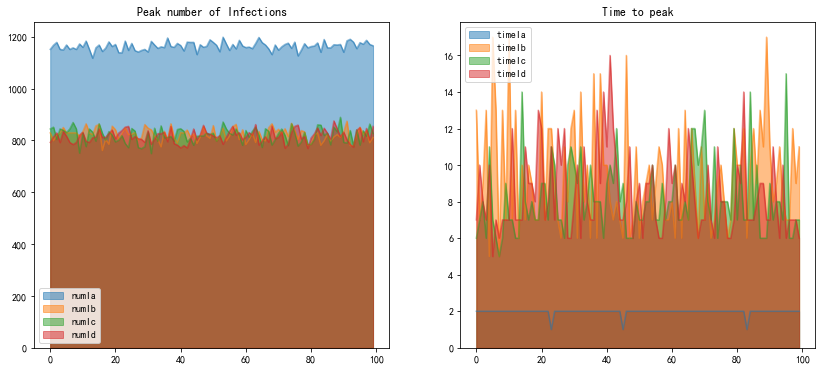

In [70]:
numI = pd.read_csv('./numberI.csv',names=['numIa', 'numIb', 'numIc', 'numId'])
timeI = pd.read_csv('./timeI.csv',names=['timeIa', 'timeIb', 'timeIc', 'timeId'])

print("实验模拟次数{}次".format(len(numI.index)))

fig, axes = plt.subplots(1, 2,figsize=(14,6))
numI.plot.area(stacked=False, ax=axes[0])
axes[0].set_title('Peak number of Infections')

timeI.plot.area(stacked=False, ax=axes[1])
axes[1].set_title('Time to peak')

plt.show()

#### 画图结果明显，求取多轮次后的平均值
- 总感染人数看下降多少
- 到达总感染人数峰值看增加（延缓）多少

In [71]:
countTimes = len(numI.index)
avgI1 = float(sum(numI['numIa']) / countTimes)
avgI2 = float(sum(numI['numIb']) / countTimes)
avgI3 = float(sum(numI['numIc']) / countTimes)
avgI4 = float(sum(numI['numId']) / countTimes)


avgT1 = float(sum(timeI['timeIa']) / countTimes)
avgT2 = float(sum(timeI['timeIb']) / countTimes)
avgT3 = float(sum(timeI['timeIc']) / countTimes)
avgT4 = float(sum(timeI['timeId']) / countTimes)

- 计算感染人数降低比率$r_i = \frac{I_1-I_i}{I_1}, (i=2,3,4)$
- 计算到达峰值时间延缓比率$rt_i = \frac{T_i-T_1}{T_1}, (i=2,3,4)$

In [72]:
r2 = float((avgI1 - avgI2)/avgI1)
r3 = float((avgI1 - avgI3)/avgI1)
r4 = float((avgI1 - avgI4)/avgI1)

rt2 = float((avgT2 - avgT1)/avgT1)
rt3 = float((avgT3 - avgT1)/avgT1)
rt4 = float((avgT4 - avgT1)/avgT1)
print(r2, r3, r4)
print(rt2, rt3, rt4)

0.2927580098715325 0.2957590245412489 0.2979345452043958
3.7715736040609142 3.1675126903553306 3.3147208121827414


## <a id=4>4. 总结</a> 

#### 实验结论
- $r_4 > r_3 > r2$,说明增加老师感染节点（局部全连接）会感染更多的人数；$r_4 > r_3$，说明教不同年级的老师会感染更多的学生
- $rt_2 > rt_4 > rt_3$，说明增加老师感染节点（局部全连接）会更快到达感染人数峰值；$rt_4 > rt_3$说明老师教同一年级到达峰值更快，也说明层内联系更多，传播越迅速，符合实际情况。

#### 需要改进的实验地方
- 参数值选取，如感染率`beta`, 康复率`gamma`，层间联系概率$p_0$，层内联系概率$p_1$，网络人群中戴口罩概率`maskp`，需要反复实验或查资料确定
- 对加入老师节点在三种网络中的不同传播（最大感染人数（峰值），或者达到峰值时间）没有明确的实验区分开
- 实验参数选择采用随机选择，可能有一定偶然性，但多次实验后效果与结论接近一致